# Analyzing Road Traffic Accidents in Great Britain (2020)

In this workshop we will get started looking at a big dataset - road traffic accidents statistics
from the UK government. This is real data of real accidents where in some cases real people
died, so treat it ethically and legally.
The government is not using a publicly accessible SQL database for this data, so for this
module we've gathered all of the data you need together and put it into an sqlite database
for you.

## Import Library

In [44]:
import sqlite3
import pandas as pd
import numpy as np
import folium
from scipy.stats import t
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from numpy import quantile,where
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
import scipy as sp
from scipy.stats import chi2
from sklearn.covariance import MinCovDet
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from jinja2 import Environment, FileSystemLoader
from sklearn.metrics import silhouette_score
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np


import warnings

# Disable warnings
warnings.filterwarnings("ignore")

In [62]:
def fetch_and_create_df(conn, table_name, column_names):
    query = f"SELECT * FROM {table_name}"
    cursor = conn.execute(query)
    data = cursor.fetchall()
    return pd.DataFrame(data, columns=column_names)

pd.set_option('display.max_columns', None)
# Connect to the database
con = sqlite3.connect("accident_data_v1.0.0_2023.db")
cur = con.cursor()

In [63]:
# Get column names for each table
table_info_queries = [
    ("accident", "acc_list"),
    ("vehicle", "veh_list"),
    ("casualty", "cas_list"),
    ("lsoa", "lsoa_list")
]

for table_name, list_name in table_info_queries:
    table_info = cur.execute(f"PRAGMA table_info({table_name})")
    column_names = [col[1] for col in table_info.fetchall()]
    exec(f"{list_name} = column_names")

# Fetch data and create DataFrames
Accident_Data = fetch_and_create_df(con, "accident", acc_list)
Vehicle_Data = fetch_and_create_df(con, "vehicle", veh_list)
Casualty_Data = fetch_and_create_df(con, "casualty", cas_list)
Lsoa_Data = fetch_and_create_df(con, "lsoa", lsoa_list)

# Filter data for the year 2020
Accident_Data = Accident_Data[Accident_Data['accident_year'] == 2020]
Vehicle_Data = Vehicle_Data[Vehicle_Data['accident_year'] == 2020]
Casualty_Data = Casualty_Data[Casualty_Data['accident_year'] == 2020]


In [64]:
# Remove the last 4 characters and the space from the 'lsoa01nm' column
Lsoa_Data['region_name'] = Lsoa_Data['lsoa01nm'].apply(lambda x: x[:-5])

In [65]:
# Define the list of region names to filter
desired_regions = ['Kingston upon Hull', 'East Riding of Yorkshire', 'North East Lincolnshire', 'North Lincolnshire']

# Use boolean indexing to filter the rows based on region_name
LSOA_fil_data = Lsoa_Data[Lsoa_Data['region_name'].isin(desired_regions)]

## Data Cleaning

Lsoa_Data, Casualty_Data, Vehicle_Data, Accident_Data

### Accident Data Cleaning

#### Sorting nans and duplicates

In [66]:
# Check for null values in each cell of the DataFrame
null_values_mask = Accident_Data.isnull().any(axis=1)

# Filter and display rows with at least one null value
rows_with_null_values = Accident_Data[null_values_mask]

# Assuming you have the DataFrame named 'rows_with_null_values'
unique_rows = rows_with_null_values.drop_duplicates(subset=['local_authority_ons_district', 'police_force'])

# Assuming you have the DataFrame named 'Accident_Data' and 'unique_rows' containing the unique combinations
selected_columns = ['local_authority_ons_district', 'police_force', 'location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude']

filtered_rows = Accident_Data.loc[
    (Accident_Data['local_authority_ons_district'].isin(unique_rows['local_authority_ons_district'])) &
    (Accident_Data['police_force'].isin(unique_rows['police_force'])), selected_columns
]

# Group by 'local_authority_ons_district' and 'police_force' and calculate the median for each group
median_rows = filtered_rows.groupby(['local_authority_ons_district', 'police_force']).median()

In [67]:
# Function to fill null values using the median values from the median_rows DataFrame
def fill_null_with_median(row):
    key = (row['local_authority_ons_district'], row['police_force'])
    if pd.isnull(row['location_easting_osgr']):
        row['location_easting_osgr'] = median_rows.loc[key, 'location_easting_osgr']
    if pd.isnull(row['location_northing_osgr']):
        row['location_northing_osgr'] = median_rows.loc[key, 'location_northing_osgr']
    if pd.isnull(row['longitude']):
        row['longitude'] = median_rows.loc[key, 'longitude']
    if pd.isnull(row['latitude']):
        row['latitude'] = median_rows.loc[key, 'latitude']
    return row

# Apply the function to fill null values in the Accident_Data DataFrame
Accident_Data = Accident_Data.apply(fill_null_with_median, axis=1)

In [68]:
# Check for duplicate rows in the Accident_Data DataFrame
duplicate_rows = Accident_Data.duplicated()

# Count the number of duplicate rows
num_duplicate_rows = duplicate_rows.sum()
print("Number of duplicate rows:", num_duplicate_rows)


Number of duplicate rows: 0


#### Cleaning categorical variables

In [69]:
# Replace all -1 and 99 with NaN in the specified columns
cols_to_replace = ['police_force','junction_detail','junction_control','local_authority_district','speed_limit',
               'second_road_class', 'second_road_number','pedestrian_crossing_human_control',
               'pedestrian_crossing_physical_facilities', 'light_conditions','weather_conditions',
               'road_surface_conditions','special_conditions_at_site', 'carriageway_hazards',
               'did_police_officer_attend_scene_of_accident','trunk_road_flag','lsoa_of_accident_location']

Accident_Data[cols_to_replace] = Accident_Data[cols_to_replace].replace([-1,99], float('nan'))

# Fill NaN in 'lsoa_of_accident_location' with 'unknown'
Accident_Data['lsoa_of_accident_location'].fillna('unknown', inplace=True)

# Replace all NaNs with the median value of each column
Accident_Data = Accident_Data.fillna(Accident_Data.median())

### Vehicle Data Cleaning

In [70]:
# Replace -1, 99, and 999 with NaNs in all columns
Vehicle_Data = Vehicle_Data.replace([-1, 99, 999], float('nan'))

# Calculate median for age_of_driver
age_of_driver_median = Vehicle_Data['age_of_driver'].median()

# Calculate mode for age_band_of_driver
age_band_of_driver_mode = Vehicle_Data['age_band_of_driver'].mode()[0]

# Replace NaNs with the calculated median and mode
Vehicle_Data['age_of_driver'].fillna(age_of_driver_median, inplace=True)
Vehicle_Data['age_band_of_driver'].fillna(age_band_of_driver_mode, inplace=True)

# Replace all NaNs with the median value of each column
Vehicle_Data = Vehicle_Data.fillna(Vehicle_Data.median())

In [71]:
# Check for duplicate rows in the Accident_Data DataFrame
duplicate_rows = Vehicle_Data.duplicated()

# Count the number of duplicate rows
num_duplicate_rows = duplicate_rows.sum()
print("Number of duplicate rows:", num_duplicate_rows)

Number of duplicate rows: 0


### Casualty Data Cleaning

In [72]:
# Check for duplicate rows in the Accident_Data DataFrame
duplicate_rows = Casualty_Data.duplicated()

# Count the number of duplicate rows
num_duplicate_rows = duplicate_rows.sum()
print("Number of duplicate rows:", num_duplicate_rows)

Number of duplicate rows: 0


In [73]:
# Replace -1 with NaNs in all columns
Casualty_Data = Casualty_Data.replace(-1, float('nan'))

# Calculate median for age_of_casualty
age_of_casualty_median = Casualty_Data['age_of_casualty'].median()

# Calculate mode for age_band_of_driver
age_band_of_casualty_mode = Casualty_Data['age_band_of_casualty'].mode()[0]

# Replace NaNs with the calculated median and mode
Casualty_Data['age_of_casualty'].fillna(age_of_casualty_median, inplace=True)
Casualty_Data['age_band_of_casualty'].fillna(age_band_of_casualty_mode, inplace=True)

# Replace all NaNs with the median value of each column
Casualty_Data = Casualty_Data.fillna(Casualty_Data.median())

### LSOA Data Cleaning

In [74]:
# Check for duplicate rows in the Accident_Data DataFrame
duplicate_rows = Lsoa_Data.duplicated()

# Count the number of duplicate rows
num_duplicate_rows = duplicate_rows.sum()
print("Number of duplicate rows:", num_duplicate_rows)

Number of duplicate rows: 0


## Project Questions

### Are there significant hours of the day, and days of the week, on which accidents occur?

In [75]:
# Select the relevant columns for analysis
time_day_data = Accident_Data[['time', 'day_of_week']]

# Convert the 'time' column to datetime format
time_day_data['time'] = pd.to_datetime(time_day_data['time'])

# Extract hour and day of the week from the 'time' column
time_day_data['hour'] = time_day_data['time'].dt.hour
time_day_data['day'] = time_day_data['time'].dt.day_name()

# Count the number of accidents for each hour of the day and each day of the week
hourly_accidents = time_day_data.groupby('hour')['time'].count()

# Select the relevant columns for analysis
day_data = Accident_Data[['date', 'day_of_week']]

# Convert the 'date' column to dateti*!me format
day_data['date'] = pd.to_datetime(day_data['date'])

# Extract day of the week from the 'date' column
day_data['day'] = day_data['date'].dt.day_name()

# Count the number of accidents for each day of the week
daily_accidents = day_data['day'].value_counts()

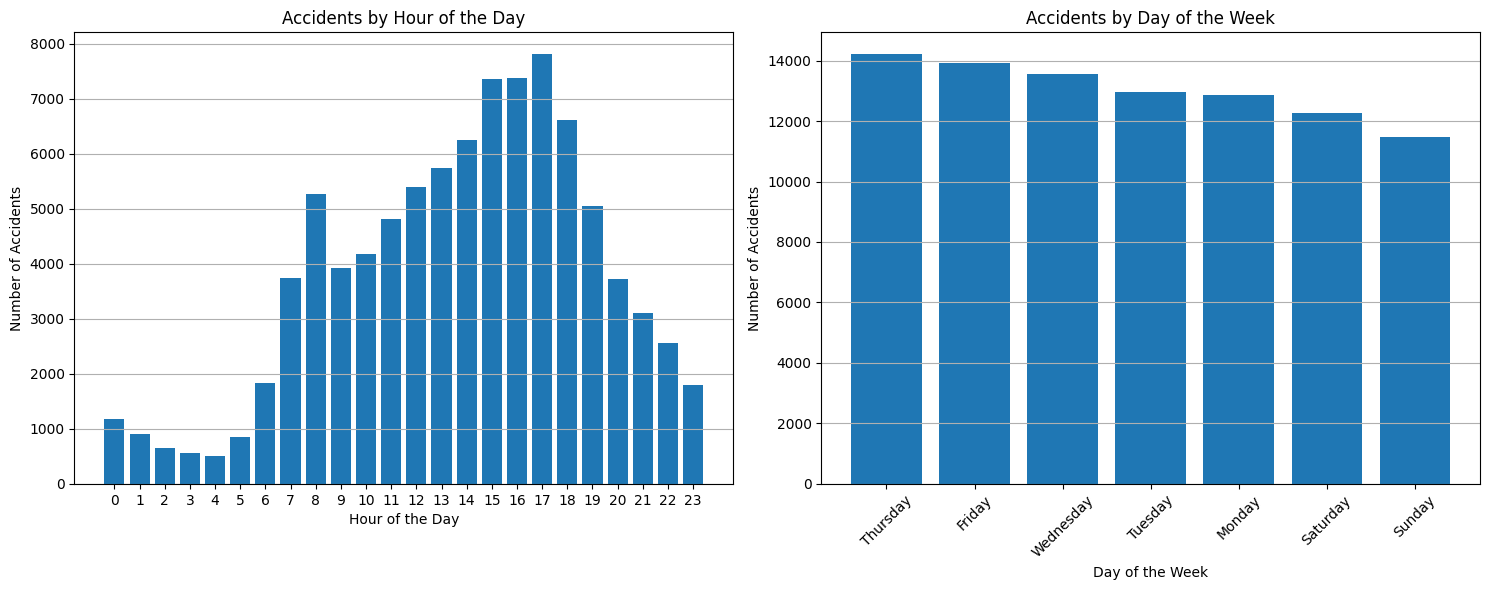

In [76]:
# Plot bar chart for hourly accidents
plt.figure(figsize=(15, 6))

# First subplot for hourly accidents
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.bar(hourly_accidents.index, hourly_accidents.values)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Accidents')
plt.title('Accidents by Hour of the Day')
plt.xticks(range(24))
plt.grid(axis='y')

# Plot bar chart for daily accidents
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.bar(daily_accidents.index, daily_accidents.values)
plt.xlabel('Day of the Week')
plt.ylabel('Number of Accidents')
plt.title('Accidents by Day of the Week')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()  # Ensures that the plots don't overlap

# Save the plots as high-quality images for journal publication
plt.savefig('Accident count by hours and days.svg', dpi=1200)
plt.show()

### For motorbikes, are there significant hours of the day, and days of the week, on which accidents occur? We suggest a focus on: Motorcycle 125cc and under, Motorcycle over 125cc and up to 500cc, and Motorcycle over 500cc.

Under the vehicle_type column, 

Motorcycle over 125cc and up to 500cc = 04
Motorcycle over 500cc = 05
Motorcycle 125cc and under = 02, 03

In [77]:
# Function to fetch the accident data for a given list of vehicle types
def fetch_vehicle_accidents(vehicle_types):
    # Convert vehicle_types to a tuple
    vehicle_types_tuple = tuple(vehicle_types)

    cur.execute(f"""
    SELECT
        COUNT(*) AS accidents_count,
        STRFTIME('%H', time, 'localtime') AS hour_of_day, day_of_week
    FROM
        accident
    JOIN
        vehicle ON accident.accident_index = vehicle.accident_index
    WHERE
        vehicle.vehicle_type IN ({', '.join('?' * len(vehicle_types_tuple))}) AND accident.accident_year = 2020
    GROUP BY
        hour_of_day, day_of_week
    ORDER BY
        accidents_count DESC;
    """, vehicle_types_tuple)

    return cur.fetchall()

# Define vehicle types for the selected categories
selected_vehicle_types = [2, 3, 4, 5]

# Fetch accidents for the selected vehicle types
selected_vehicle_data = fetch_vehicle_accidents(selected_vehicle_types)

# Convert the list to a pandas DataFrame
columns = ['accidents_count', 'hour_of_day', 'day_of_week']
selected_vehicle_df = pd.DataFrame(selected_vehicle_data, columns=columns)


he line on each bar of the plot is called an "error bar" or "confidence interval." It represents the uncertainty or variability in the data for each hour of the day. In this context, the error bar shows the confidence interval for the mean accident count at each hour.

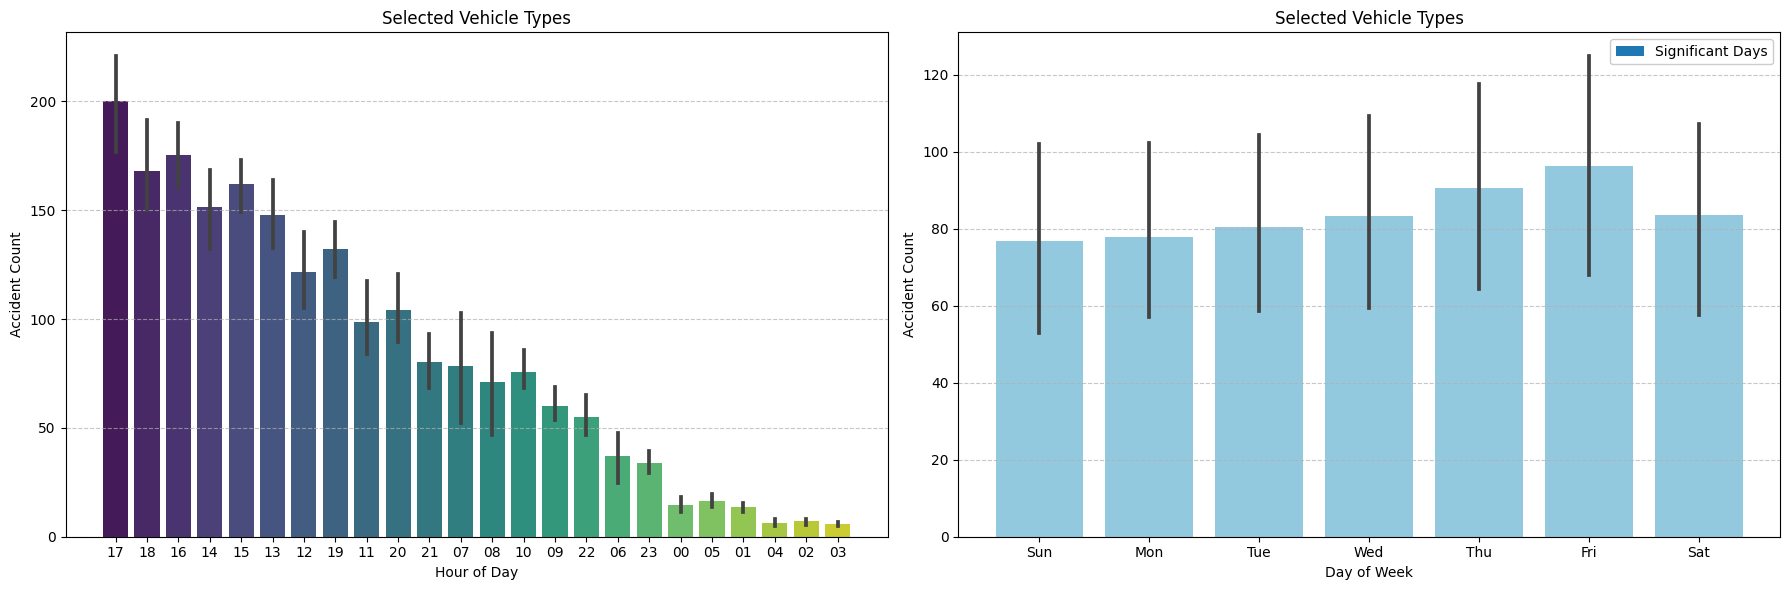

In [79]:
# Function to plot significant hours of the day for a specific dataframe
def plot_significant_hours(df, category_name, ax):
    sns.barplot(x='hour_of_day', y='accidents_count', data=df, palette='viridis', ax=ax)
    ax.set_title(category_name)
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Accident Count')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Determine the significance threshold using the IQR method
    q1 = df['accidents_count'].quantile(0.25)
    q3 = df['accidents_count'].quantile(0.75)
    iqr = q3 - q1
    significance_threshold = q3 + 1.5 * iqr
    
    # Highlight significant hours on the plot
    significant_hours = df[df['accidents_count'] >= significance_threshold]['hour_of_day'].unique()
    ax.bar(significant_hours, [df[df['hour_of_day'] == hour]['accidents_count'].max() for hour in significant_hours],
           color='red', alpha=0.5)

# Function to plot significant days of the week for a specific DataFrame
def plot_significant_days(df, category_name, max_accidents, ax):
    sns.barplot(x='day_of_week', y='accidents_count', data=df, color='skyblue', ax=ax)
    ax.set_title(category_name)
    ax.set_xlabel('Day of Week')
    ax.set_ylabel('Accident Count')
    ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Determine the significance threshold using the IQR method
    q1 = df['accidents_count'].quantile(0.25)
    q3 = df['accidents_count'].quantile(0.75)
    iqr = q3 - q1
    significance_threshold = q3 + 1.5 * iqr
    
    # Highlight significant days on the plot
    significant_days = df[df['accidents_count'] >= significance_threshold]['day_of_week'].unique()
    ax.bar(significant_days, [df[df['day_of_week'] == day]['accidents_count'].max() for day in significant_days],
           color='red', alpha=0.5, label='Significant Days')

# Create a single plot with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot significant hours of the day for the selected vehicle types
plot_significant_hours(selected_vehicle_df, 'Selected Vehicle Types', axes[0])

# Calculate max_accidents for selected_vehicle_df
max_accidents = selected_vehicle_df['accidents_count'].max()

# Plot significant days of the week for the selected vehicle types
plot_significant_days(selected_vehicle_df, 'Selected Vehicle Types', max_accidents, axes[1])

# Add a legend showing the significant days for the second plot
axes[1].legend(loc='upper right', framealpha=1)

# Adjust layout and spacing
plt.tight_layout()

# Save the plots as high-quality images for journal publication
plt.savefig('Vehicle count by hours and days.svg', dpi=1200)
# Display the plot
plt.show()


### For pedestrians involved in accidents, are there significant hours of the day, and days of the week, on which they are more likely to be involved?

In [108]:
# Define the SQL query to join the accident, vehicle, and casualty tables
sql_query = """
SELECT 
    STRFTIME('%H', accident.time, 'localtime') AS hour_of_day,
    accident.day_of_week, 
    casualty.casualty_class
FROM 
    accident
JOIN 
    vehicle ON accident.accident_index = vehicle.accident_index
JOIN 
    casualty ON accident.accident_index = casualty.accident_index
WHERE
    casualty.casualty_class = 3 AND accident.accident_year = 2020;  -- 3 indicates pedestrians in the casualty_class column, 
"""

# Execute the SQL query and load data into a DataFrame
pedestrian_data = pd.read_sql_query(sql_query, con)

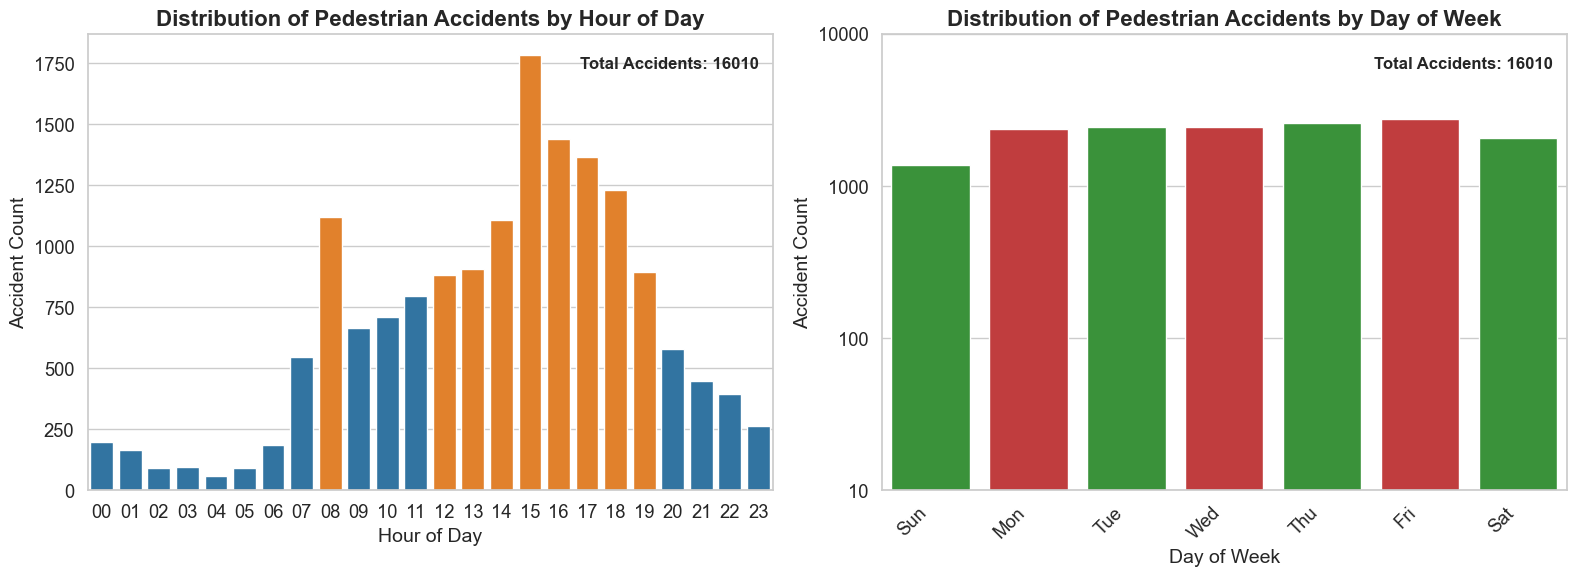

In [109]:
# Calculate the accident count for each hour of the day
hourly_counts = pedestrian_data['hour_of_day'].value_counts()

# Sort the hourly_counts in descending order
hourly_counts_sorted = hourly_counts.sort_index(ascending=True)

# Define a custom color palette for the first plot
high_count_color = '#ff7f0e'
low_count_color = '#1f77b4'
custom_palette1 = [high_count_color if count > 800 else low_count_color for count in hourly_counts_sorted.values]
day_names = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

# Set the style and context for the plots
sns.set(style='whitegrid', font_scale=1.2)

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot 1: Distribution of pedestrian accidents across different hours of the day
sns.barplot(x=hourly_counts_sorted.index, y=hourly_counts_sorted.values, palette=custom_palette1, ax=axes[0])
axes[0].set_title('Distribution of Pedestrian Accidents by Hour of Day', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Hour of Day', fontsize=14)
axes[0].set_ylabel('Accident Count', fontsize=14)

# Plot 2: Distribution of pedestrian accidents across different days of the week
# Reorder the 'day_of_week' categories based on the accident counts
ordered_days = pedestrian_data['day_of_week'].value_counts().index
custom_palette2 = sns.color_palette(['#2ca02c', '#d62728'])  # Two colors for the second plot
sns.countplot(data=pedestrian_data, x='day_of_week', palette=custom_palette2, ax=axes[1])
axes[1].set_title('Distribution of Pedestrian Accidents by Day of Week', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Day of Week', fontsize=14)
axes[1].set_xticklabels(day_names, rotation=45, ha='right')
axes[1].set_ylabel('Accident Count', fontsize=14)

# Set y-axis ticks for the second plot (log scale)
y_ticks = [10, 100, 1000, 10000, 100000]
axes[1].set_yscale('log')  # Use a logarithmic scale for the y-axis
axes[1].set_yticks(y_ticks)
axes[1].set_yticklabels(y_ticks)

# Set the y-axis limit for the second plot to 10000
axes[1].set_ylim(10, 10000)

# Add annotations to the plots
for ax in axes:
    total_accidents = len(pedestrian_data)
    ax.text(0.98, 0.95, f'Total Accidents: {total_accidents}', transform=ax.transAxes, ha='right', va='top',
            fontsize=12, fontweight='bold')

# Adjust layout and spacing
plt.tight_layout()

# Save the plots as high-quality images for journal publication
plt.savefig('pedestrian_accidents_journal.svg', dpi=1200)

# Display the plot
plt.show()


### Using the apriori algorithm, explore the impact of selected variables on accident severity. 

In [84]:
# Merge the datasets based on the 'accident_index' and 'vehicle_reference' columns
merged_data = pd.merge(Vehicle_Data, Accident_Data, on='accident_index')
merged_data = pd.merge(merged_data, Casualty_Data, on=['accident_index', 'vehicle_reference'])


# Select relevant features for analysis
selected_features = [
    # Vehicle information
    'vehicle_type','vehicle_direction_to','first_point_of_impact','sex_of_driver', 'age_of_driver',
    'age_of_vehicle','engine_capacity_cc','accident_severity',
    # Accident details
    'day_of_week','police_force','local_authority_district', 'light_conditions','weather_conditions',
    'road_surface_conditions','road_type', 'speed_limit',
    # Casualty information
    'age_of_casualty','engine_capacity_cc','age_of_driver','casualty_severity'
]

# Filter the data to include only the selected features
selected_data = merged_data[selected_features]


# Prepare the data for analysis
X = selected_data.drop('accident_severity', axis=1)  # Features
y = selected_data['accident_severity']  # Target variable

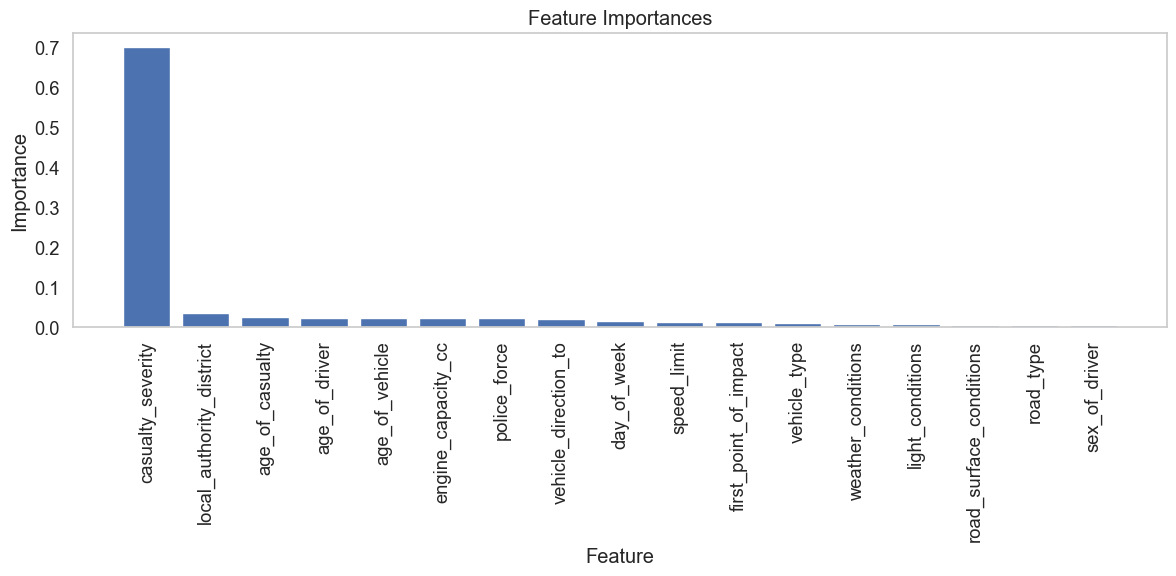

In [85]:
# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Fit and transform the scaler on the data
X_scaled = scaler.fit_transform(X)

# Create a Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Fit the Random Forest model to the scaled data
rf.fit(X_scaled, y)

# Get feature importances from the model
importances = rf.feature_importances_

# Create a DataFrame to store the feature importances
feature_importances_df = pd.DataFrame({'feature': X.columns, 'importance': importances})

# Sort the features by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.bar(feature_importances_df['feature'], feature_importances_df['importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.grid(False)  # Remove the vertical lines (grid)
plt.tight_layout()
plt.show()

In [86]:
# acc_subset = accident_df[['accident_severity','speed_limit','weather_conditions']]
acc_subset = selected_data[['accident_severity','police_force','casualty_severity',
                            'engine_capacity_cc','age_of_casualty']]

In [87]:
# Convert 'engine_capacity_cc' to a categorical data type
acc_subset['engine_capacity_cc'] = acc_subset['engine_capacity_cc'].astype('category')

# Create dummies for categorical columns
acc_severity_dum = pd.get_dummies(acc_subset['accident_severity'], prefix='severity')
police_force_dum = pd.get_dummies(acc_subset['police_force'], prefix='police')
casualty_severity_dum = pd.get_dummies(acc_subset['casualty_severity'], prefix='casualty')
engine_capacity_cc_dum = pd.get_dummies(acc_subset['engine_capacity_cc'], prefix='engine')
age_of_casualty_dum = pd.get_dummies(acc_subset['age_of_casualty'], prefix='age')

In [88]:
acc_subset_dum= pd.concat([acc_severity_dum, police_force_dum, casualty_severity_dum,
                          engine_capacity_cc_dum,age_of_casualty_dum], axis=1)


In [89]:
acc_frequency = apriori(acc_subset_dum, min_support=0.2,use_colnames=True)
acc_frequency

,support,itemsets
0,0.211917,(severity_2)
1,0.769265,(severity_3)
2,0.209771,(police_1.0)
3,0.813459,(casualty_3)
4,0.274893,(engine_1597.0)
5,0.274893,(engine_1597.0)
6,0.769265,"(severity_3, casualty_3)"
7,0.207531,"(engine_1597.0, severity_3)"
8,0.207531,"(engine_1597.0, severity_3)"
9,0.213812,"(engine_1597.0, casualty_3)"


In [90]:
rules = association_rules(acc_frequency, metric="lift", min_threshold=0.8)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(severity_3),(casualty_3),0.769265,0.813459,0.769265,1.000000,1.229319,0.143500,inf,0.808467
1,(casualty_3),(severity_3),0.813459,0.769265,0.769265,0.945672,1.229319,0.143500,4.247089,1.000000
2,(engine_1597.0),(severity_3),0.274893,0.769265,0.207531,0.754949,0.981390,-0.003935,0.941579,-0.025486
3,(severity_3),(engine_1597.0),0.769265,0.274893,0.207531,0.269778,0.981390,-0.003935,0.992994,-0.075944
4,(engine_1597.0),(casualty_3),0.274893,0.813459,0.213812,0.777799,0.956163,-0.009803,0.839515,-0.059468
5,(casualty_3),(engine_1597.0),0.813459,0.274893,0.213812,0.262843,0.956163,-0.009803,0.983653,-0.197287
6,"(engine_1597.0, severity_3)",(casualty_3),0.207531,0.813459,0.207531,1.000000,1.229319,0.038713,inf,0.235392
7,"(engine_1597.0, casualty_3)",(severity_3),0.213812,0.769265,0.207531,0.970623,1.261753,0.043053,7.854194,0.263870
8,"(severity_3, casualty_3)",(engine_1597.0),0.769265,0.274893,0.207531,0.269778,0.981390,-0.003935,0.992994,-0.075944
9,(engine_1597.0),"(severity_3, casualty_3)",0.274893,0.769265,0.207531,0.754949,0.981390,-0.003935,0.941579,-0.025486


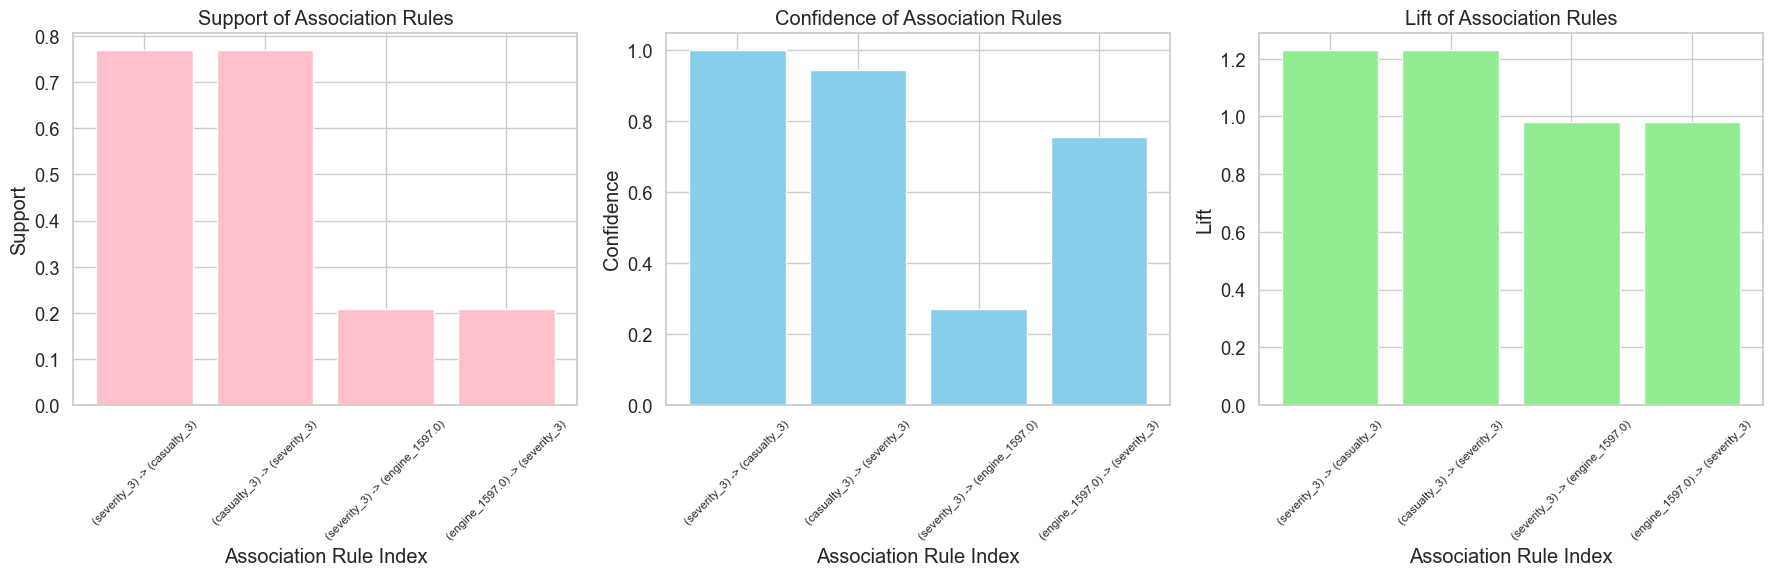

In [110]:
# Sample association rule mining results for Support, Confidence, and Lift
data_support = {
    'antecedents': ['(severity_3)', '(casualty_3)', '(severity_3)', '(engine_1597.0)'],
    'consequents': ['(casualty_3)', '(severity_3)', '(engine_1597.0)', '(severity_3)'],
    'support': [0.769263, 0.769263, 0.207532, 0.207532]
}

data_confidence = {
    'antecedents': ['(severity_3)', '(casualty_3)', '(severity_3)', '(engine_1597.0)'],
    'consequents': ['(casualty_3)', '(severity_3)', '(engine_1597.0)', '(severity_3)'],
    'confidence': [1.000000, 0.945672, 0.269781, 0.754949]
}

data_lift = {
    'antecedents': ['(severity_3)', '(casualty_3)', '(severity_3)', '(engine_1597.0)'],
    'consequents': ['(casualty_3)', '(severity_3)', '(engine_1597.0)', '(severity_3)'],
    'lift': [1.229321, 1.229321, 0.981392, 0.981392]
}

# Create DataFrames from the association rule mining results
df_support = pd.DataFrame(data_support)
df_confidence = pd.DataFrame(data_confidence)
df_lift = pd.DataFrame(data_lift)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot the Support values
axes[0].bar(df_support.index, df_support['support'], color='pink')
axes[0].set_xlabel('Association Rule Index')
axes[0].set_ylabel('Support')
axes[0].set_title('Support of Association Rules')
axes[0].set_xticks(df_support.index)
axes[0].set_xticklabels(df_support['antecedents'] + ' -> ' + df_support['consequents'], rotation=45, fontsize=8.5)

# Plot the Confidence values
axes[1].bar(df_confidence.index, df_confidence['confidence'], color='skyblue')
axes[1].set_xlabel('Association Rule Index')
axes[1].set_ylabel('Confidence')
axes[1].set_title('Confidence of Association Rules')
axes[1].set_xticks(df_confidence.index)
axes[1].set_xticklabels(df_confidence['antecedents'] + ' -> ' + df_confidence['consequents'], rotation=45, fontsize=8.5)

# Plot the Lift values
axes[2].bar(df_lift.index, df_lift['lift'], color='lightgreen')
axes[2].set_xlabel('Association Rule Index')
axes[2].set_ylabel('Lift')
axes[2].set_title('Lift of Association Rules')
axes[2].set_xticks(df_lift.index)
axes[2].set_xticklabels(df_lift['antecedents'] + ' -> ' + df_lift['consequents'], rotation=45, fontsize=8.5)

plt.tight_layout()

# Save the plots as high-quality images for journal publication
plt.savefig('apriori distribution for association rules.svg', dpi=2000)
plt.show()


These results appear to be from an association rule mining analysis using the Apriori algorithm or a similar technique. Each row represents an association rule, and each column provides relevant metrics for interpreting the rules. Let's interpret the findings for each rule:

1. Rule: severity_3 => casualty_3
   - Antecedents: The itemset 'severity_3' represents accidents with severity level 3.
   - Consequents: The itemset 'casualty_3' represents accidents with casualty level 3.
   - Antecedent Support: The support of accidents with severity level 3 is approximately 76.93%.
   - Consequent Support: The support of accidents with casualty level 3 is approximately 81.35%.
   - Support: The support of the rule (severity_3 => casualty_3) is approximately 76.93%.
   - Confidence: The confidence of the rule is 100%. This means that all accidents with severity level 3 also have casualty level 3.
   - Lift: The lift of the rule is approximately 1.23. Lift indicates whether the occurrence of one item affects the occurrence of another. A lift value greater than 1 suggests a positive relationship between the antecedents and consequents.
   - Leverage: The leverage of the rule is approximately 0.1435. Leverage measures the difference between the observed frequency of the rule and what would be expected if the antecedents and consequents were independent. A positive value suggests that the antecedents and consequents appear together more frequently than expected by chance.
   - Conviction: The conviction of the rule is infinite (inf). Conviction is a measure of how much the rule is dependent on the antecedents. An infinite value indicates a strong dependency.

2. Rule: casualty_3 => severity_3
   - Antecedents: The itemset 'casualty_3' represents accidents with casualty level 3.
   - Consequents: The itemset 'severity_3' represents accidents with severity level 3.
   - Other metrics: The metrics have similar interpretations as in the first rule but reflect the opposite direction of the association. It shows the relationship between accidents with casualty level 3 and accidents with severity level 3.

The rest of the rules follow the same format as the first two rules, representing associations between different combinations of severity levels, casualty levels, and vehicle engine capacity. The metrics provide insights into the strength and direction of these associations.

Keep in mind that association rule mining can provide valuable insights into potential patterns and relationships in the data. However, further analysis and domain expertise are necessary to understand the context and implications of these findings. Additionally, depending on the dataset and the specific problem, some rules may be more relevant and actionable than others.

### Identify accidents in our region: Kingston upon Hull, Humberside, and the East Riding of Yorkshire etc. You can do this by filtering on LSOA, or police region or another method if you can find one. Run clustering on this data. What do these clusters reveal about the distribution of accidents in our region? 

In [92]:
# Join the Accident_Data and Lsoa_Data DataFrames based on police_force and lsoa01cd columns
query = """
SELECT * 
FROM accident
JOIN lsoa ON accident.lsoa_of_accident_location = lsoa.lsoa01cd
WHERE accident.police_force = 16 AND accident.accident_year = 2020;
"""

# Execute the SQL query and load data into a DataFrame
accidents_region_df = pd.read_sql_query(query, con)

In [93]:
# Remove the last 4 characters and the space from the 'lsoa01nm' column
accidents_region_df['region_name'] = accidents_region_df['lsoa01nm'].apply(lambda x: x[:-5])

# Display the extracted region names
accidents_region_df['region_name'].unique()

array(['Kingston upon Hull', 'North Lincolnshire',
       'North East Lincolnshire', 'East Riding of Yorkshire'],
      dtype=object)

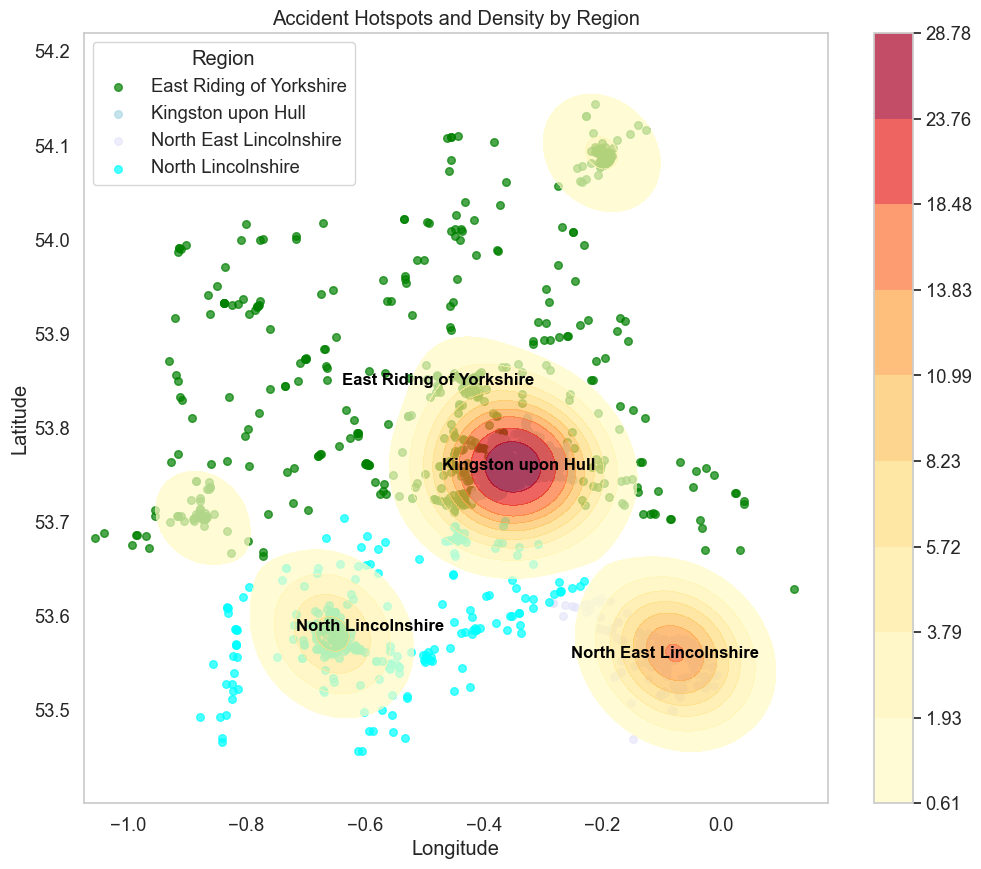

In [94]:
# Select features for clustering
features_for_clustering = ['latitude', 'longitude', 'speed_limit', 'number_of_casualties', 'number_of_vehicles']
X = accidents_region_df[features_for_clustering]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a DBSCAN clustering model
dbscan = DBSCAN(eps=0.1, min_samples=10)
accidents_region_df['cluster_dbscan'] = dbscan.fit_predict(X_scaled)

# Filter out noise points
hotspot_data = accidents_region_df[accidents_region_df['cluster_dbscan'] != -1]

# Calculate density and scale it for hotspot data
cluster_counts = hotspot_data['cluster_dbscan'].value_counts()
max_count = cluster_counts.max()
min_count = cluster_counts.min()

hotspot_data['scaled_density'] = (cluster_counts[hotspot_data['cluster_dbscan']].values - min_count) / (max_count - min_count)

# Define region colors
region_colors = {'Kingston upon Hull': 'lightblue', 'East Riding of Yorkshire': 'green',
                 'North East Lincolnshire': 'lavender', 'North Lincolnshire': 'cyan'}

# Create a scatter plot with region colors and a heatmap for hotspot density
plt.figure(figsize=(12, 10))

for region, data in accidents_region_df.groupby('region_name'):
    plt.scatter(data['longitude'], data['latitude'], color=region_colors[region], 
                label=region, alpha=0.7, s=30)

sns.kdeplot(data=hotspot_data, x='longitude', y='latitude', cmap='YlOrRd', shade=True, thresh=0.05, cbar=True, alpha=0.7)

for region, data in accidents_region_df.groupby('region_name'):
    centroid_longitude = data['longitude'].mean()
    centroid_latitude = data['latitude'].mean()
    plt.text(centroid_longitude, centroid_latitude, region, fontsize=12, ha='center', va='center', 
             color='black', fontweight='bold')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Accident Hotspots and Density by Region')
plt.legend(title='Region')
plt.grid(False)

# Save the plots as high-quality images for journal publication
plt.savefig('Accident Hotspots and Density by Region.svg', dpi=1200)
plt.show()


### Using outlier detection methods, identify unusual entries in your data set. Should you keep these entries in your data? 

while numerous columns exist in the different datasets, we would focus on a few which we use frequently.
For the Accident data, we would focus on the following features: longitude, latitude, number_of_casualties
For teh Vehicle data, age_of_driver, age_of_vehicle, engine_capacity_cc
For the Casualty data, age_of_casualty

#### Age of Vehicle and Driver Outlier Detection - Local Outlier Factor

In [95]:
long_lag_df = Accident_Data[['longitude', 'latitude']]
Age_driver_vehicle = Vehicle_Data[['age_of_driver', 'age_of_vehicle']]

# Scale the data before applying clustering algorithms
scaler = StandardScaler()
long_lag_scaled = scaler.fit_transform(long_lag_df)
Age_driver_vehicle_scaled = scaler.fit_transform(Age_driver_vehicle)

In [96]:
Vehicle_Data.age_of_driver.max()

100.0

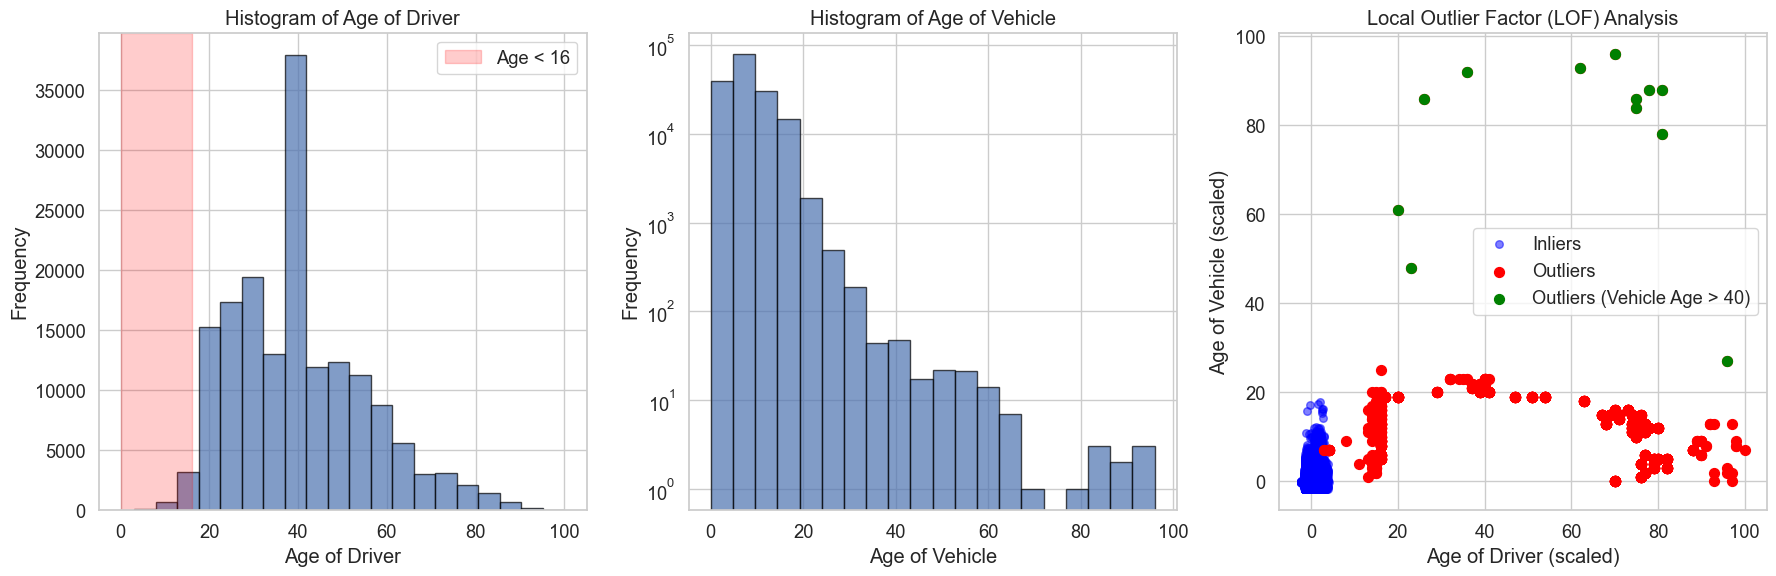

In [97]:
# Local Outlier Factor (LOF) Analysis
lof_model = LocalOutlierFactor(n_neighbors=20, contamination='auto')  # 'auto' to estimate outlier fraction
lof_scores = lof_model.fit_predict(Age_driver_vehicle_scaled)
lof_outliers = Age_driver_vehicle[lof_scores == -1]
lof_outliers_filtered = lof_outliers[lof_outliers['age_of_vehicle'] > 25]

# Create a single figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Histogram - Age of Driver
n, bins, patches = axes[0].hist(Vehicle_Data['age_of_driver'], bins=20, edgecolor='black', alpha=0.7)
axes[0].axvspan(0, 16, color='red', alpha=0.2, label='Age < 16')
axes[0].set_xlabel('Age of Driver')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Age of Driver')
axes[0].grid(True)
axes[0].legend()

# Histogram - Age of Vehicle
n, bins, patches = axes[1].hist(Vehicle_Data['age_of_vehicle'], bins=20, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Age of Vehicle')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Age of Vehicle')
axes[1].grid(True)
axes[1].set_yscale('log')

# Visualization - LOF Outliers
axes[2].scatter(Age_driver_vehicle_scaled[:, 0], Age_driver_vehicle_scaled[:, 1], c='blue', s=30, alpha=0.5, label='Inliers')
axes[2].scatter(lof_outliers['age_of_driver'], lof_outliers['age_of_vehicle'], c='red', s=50, label='Outliers')
axes[2].scatter(lof_outliers_filtered['age_of_driver'], lof_outliers_filtered['age_of_vehicle'], c='green', s=50, label='Outliers (Vehicle Age > 40)')
axes[2].set_xlabel('Age of Driver (scaled)')
axes[2].set_ylabel('Age of Vehicle (scaled)')
axes[2].set_title('Local Outlier Factor (LOF) Analysis')
axes[2].legend()
axes[2].grid(True)

# Adjust the layout to avoid overlapping of titles and labels
plt.tight_layout()

# Save the plots as high-quality images for journal publication
plt.savefig('Local Outlier Factor (LOF) Analysis.svg', dpi=1200)
plt.show()


#### Location Outlier detection - Isolation_Rorest, Kmeans

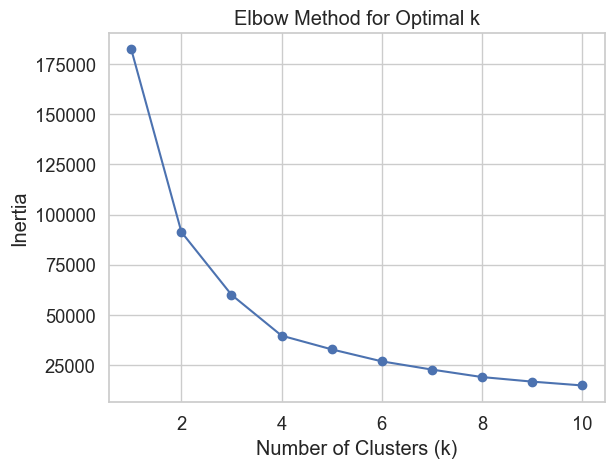

In [98]:
# Fit KMeans for different values of k
inertia = []
k_values = range(1, 11)  # Trying k from 1 to 10
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(long_lag_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


In [99]:
# KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
label = kmeans.fit_predict(long_lag_scaled)
centroids = kmeans.cluster_centers_


# Create an imputer object
imputer = SimpleImputer(strategy='mean')
numerical_data = Accident_Data.select_dtypes(include='number')

# Impute missing values in the numerical data
numerical_data_imputed = imputer.fit_transform(numerical_data)
# Create an IsolationForest object
isolation_forest = IsolationForest(contamination='auto', random_state=42)
# Fit the IsolationForest to the imputed numerical data
isolation_forest.fit(numerical_data_imputed)
# Predict outliers using the isolation forest
outlier_flags = isolation_forest.predict(numerical_data_imputed)
# Add the outlier_flags as a new column to the original dataframe
Accident_Data['outlier'] = outlier_flags

# The 'outlier' column will have values of -1 for outliers and 1 for inliers
# Count the number of outliers in the 'outlier' column
outlier_counts = Accident_Data['outlier'].value_counts()
# Get the number of outliers (value -1)
num_outliers = outlier_counts[-1]
print("Number of outliers:", num_outliers)

# Separate the data into outliers and normal data
outliers = Accident_Data[Accident_Data['outlier'] == -1]
normal_data = Accident_Data[Accident_Data['outlier'] == 1]

Number of outliers: 9489


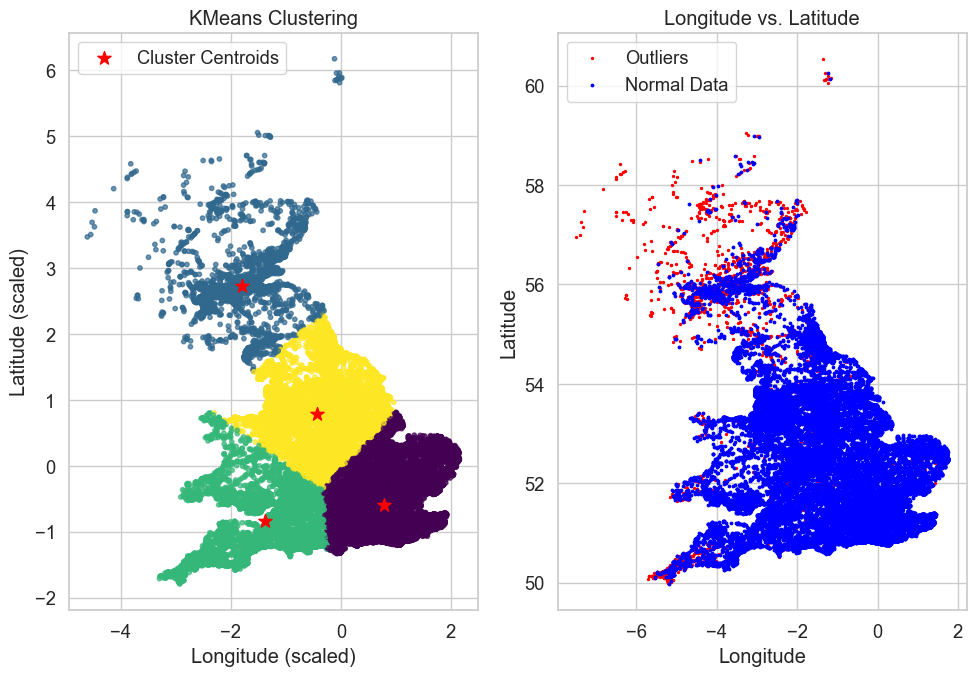

In [100]:
plt.figure(figsize=(10, 7))

# KMeans Clustering Plot
plt.subplot(1, 2, 1)
plt.scatter(long_lag_scaled[:, 0], long_lag_scaled[:, 1], c=label, cmap='viridis', s=10, alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker="*", s=100, label='Cluster Centroids')
plt.xlabel('Longitude (scaled)')
plt.ylabel('Latitude (scaled)')
plt.title('KMeans Clustering')
plt.legend()
plt.grid(True)

# Scatter plots of longitude and latitude for outliers and normal data
plt.subplot(1, 2, 2)
plt.scatter(outliers['longitude'], outliers['latitude'], color='red', s=2, label='Outliers')
plt.scatter(normal_data['longitude'], normal_data['latitude'], color='blue', s=3, label='Normal Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Longitude vs. Latitude')
plt.legend()

# Adjust the layout to avoid overlapping of titles and labels
plt.tight_layout()

# Save the plots as high-quality images for journal publication
plt.savefig('Longitude vs. Latitude.svg', dpi=1200)
plt.show()



### Can you develop a classification model using the provided data that accurately predicts fatal injuries sustained in road traffic accidents, with the aim of informing and improving road safety measures?

#### Step 1: Data Preparation and Feature Engineering

## classification model

In [101]:
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler

In [102]:
merged_dataset = Vehicle_Data.merge(Accident_Data, on='accident_index', how='inner')
# Then, join Casualty_Data on 'accident_index'
merged_dataset = merged_dataset.merge(Casualty_Data, on='accident_index', how='inner')

# Assuming merged_dataset is your DataFrame
y_labels = merged_dataset['accident_severity'].apply(lambda x: True if x == 1 else False)

merged_dataset_bal, y_labels_bal = RandomUnderSampler().fit_resample(merged_dataset, y_labels)

merged_dataset_bal = merged_dataset_bal.drop(['accident_severity', 'did_police_officer_attend_scene_of_accident',
                                             'casualty_severity'], axis=1)

merged_dataset_bal = merged_dataset_bal.select_dtypes(include=[np.number])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'vehicle_index'),
  Text(1, 0, 'vehicle_manoeuvre'),
  Text(2, 0, 'junction_location'),
  Text(3, 0, 'sex_of_driver'),
  Text(4, 0, 'driver_home_area_type'),
  Text(5, 0, 'number_of_casualties'),
  Text(6, 0, 'local_authority_district'),
  Text(7, 0, 'first_road_class'),
  Text(8, 0, 'speed_limit'),
  Text(9, 0, 'junction_detail'),
  Text(10, 0, 'second_road_class'),
  Text(11, 0, 'urban_or_rural_area'),
  Text(12, 0, 'outlier'),
  Text(13, 0, 'casualty_index'),
  Text(14, 0, 'casualty_reference')])

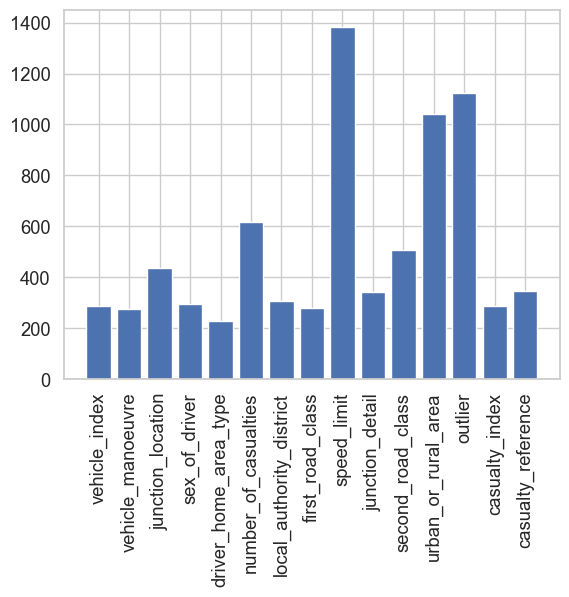

In [103]:
# Generate SelectKBest object with f_classif scoring function
k_best = SelectKBest(score_func=f_classif, k=15)

# Fit and transform the object on the balanced dataset
k_best = k_best.fit(merged_dataset_bal, y_labels_bal)

# Get the indices of the selected features
selected_feature_indices = k_best.get_support()

# Get the names of the selected features
names = k_best.feature_names_in_[selected_feature_indices]

scores = k_best.scores_[selected_feature_indices]

plt.bar(names, scores)
plt.xticks(rotation="vertical")


### Base Model

In [104]:
tree = DecisionTreeClassifier(min_samples_leaf=100)

# Selected feature columns
selected_features = ['vehicle_index', 'junction_location', 'sex_of_driver',
       'local_authority_district', 'speed_limit', 'casualty_index',
       'second_road_class', 'urban_or_rural_area', 'age_of_casualty',
       'number_of_casualties']

# Extract the selected features from the balanced dataset
X_selected = merged_dataset_bal[selected_features]

# Normalize the numerical features in the merged dataset
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_labels_bal, test_size=0.2, random_state=42)

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
# Perform cross-validation with 10 folds and get the result estimator
result_trees = cross_validate(tree, X_train, y_train, cv=10, scoring="accuracy", return_estimator=True)

# Display the accuracy scores from cross-validation
print("Accuracy Scores:", result_trees['test_score'])

# Calculate the average accuracy across all folds
average_accuracy = np.mean(result_trees['test_score'])
print("Average Accuracy:", average_accuracy)


X_train shape: (6769, 10)
X_test shape: (1693, 10)
y_train shape: (6769,)
y_test shape: (1693,)
Accuracy Scores: [0.71196455 0.71196455 0.73707533 0.70753323 0.74298375 0.7267356
 0.71196455 0.72082718 0.70310192 0.69970414]
Average Accuracy: 0.7173854806709027


#### First upgrade on base model

In [105]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the grid search
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, scoring="accuracy", cv=10)
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)


Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Accuracy: 0.7754483756216514


#### Second upgrade on model

In [106]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Define the feature columns
feature_columns = ['vehicle_index', 'junction_location', 'local_authority_district',
                   'speed_limit', 'junction_detail', 'second_road_class',
                   'urban_or_rural_area', 'casualty_index', 'age_of_casualty',
                   'age_band_of_casualty']


# Split the balanced data into test and training samples
X_train, X_test, y_train, y_test = train_test_split(merged_dataset_bal[feature_columns], y_labels_bal, test_size=0.2, random_state=42)

# Create classifiers
gb_classifier = GradientBoostingClassifier(random_state=42)
tree_classifier = DecisionTreeClassifier(random_state=42)
forest_classifier = RandomForestClassifier(random_state=42)

# Create a Voting classifier with Decision Tree and Random Forest
voting_classifier = VotingClassifier(
    estimators=[
        ('tree', tree_classifier),
        ('forest', forest_classifier)
    ],
    voting='soft'  # Use soft voting for probability-based predictions
)

# Fit the models
gb_classifier.fit(X_train, y_train)
tree_classifier.fit(X_train, y_train)
forest_classifier.fit(X_train, y_train)
voting_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_gb = gb_classifier.predict(X_test)
y_pred_tree = tree_classifier.predict(X_test)
y_pred_forest = forest_classifier.predict(X_test)
y_pred_voting = voting_classifier.predict(X_test)

# Calculate the accuracy on the test set for each model
test_accuracy_gb = accuracy_score(y_test, y_pred_gb)
test_accuracy_tree = accuracy_score(y_test, y_pred_tree)
test_accuracy_forest = accuracy_score(y_test, y_pred_forest)
test_accuracy_voting = accuracy_score(y_test, y_pred_voting)

# Generate classification reports
report_gb = classification_report(y_test, y_pred_gb, target_names=["Non-Fatal", "Fatal"])
report_tree = classification_report(y_test, y_pred_tree, target_names=["Non-Fatal", "Fatal"])
report_forest = classification_report(y_test, y_pred_forest, target_names=["Non-Fatal", "Fatal"])
report_voting = classification_report(y_test, y_pred_voting, target_names=["Non-Fatal", "Fatal"])

print("Gradient Boosting Test Accuracy:", test_accuracy_gb)
print("Decision Tree Test Accuracy:", test_accuracy_tree)
print("Random Forest Test Accuracy:", test_accuracy_forest)
print("Voting Classifier Test Accuracy:", test_accuracy_voting)

print("\n--- Gradient Boosting Classifier ---")
print(report_gb)

print("\n--- Decision Tree Classifier ---")
print(report_tree)

print("\n--- Random Forest Classifier ---")
print(report_forest)

print("\n--- Voting Classifier ---")
print(report_voting)


Gradient Boosting Test Accuracy: 0.7330183106910809
Decision Tree Test Accuracy: 0.8145304193738925
Random Forest Test Accuracy: 0.8470171293561725
Voting Classifier Test Accuracy: 0.8145304193738925

--- Gradient Boosting Classifier ---
              precision    recall  f1-score   support

   Non-Fatal       0.74      0.71      0.73       838
       Fatal       0.73      0.75      0.74       855

    accuracy                           0.73      1693
   macro avg       0.73      0.73      0.73      1693
weighted avg       0.73      0.73      0.73      1693


--- Decision Tree Classifier ---
              precision    recall  f1-score   support

   Non-Fatal       0.85      0.76      0.80       838
       Fatal       0.79      0.87      0.83       855

    accuracy                           0.81      1693
   macro avg       0.82      0.81      0.81      1693
weighted avg       0.82      0.81      0.81      1693


--- Random Forest Classifier ---
              precision    recall  f1-sc

### Third upgrade

Fitting 5 folds for each of 162 candidates, totalling 810 fits


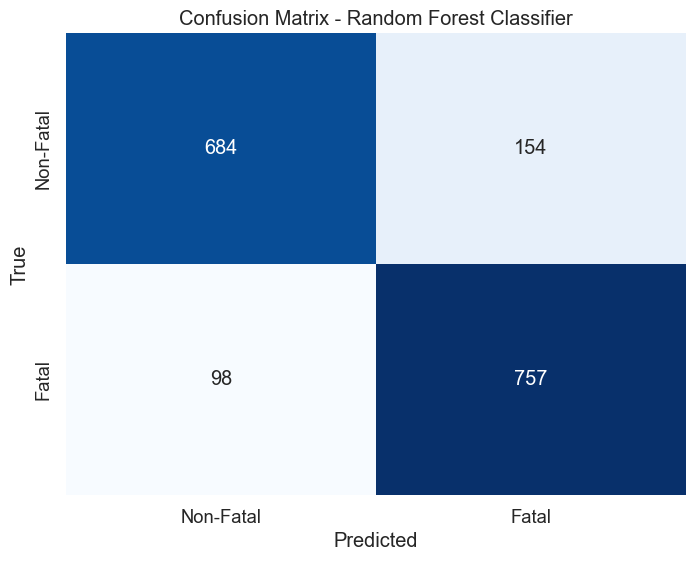

Best Random Forest Parameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Test Accuracy: 0.8511518015357353

--- Random Forest Classifier ---
              precision    recall  f1-score   support

   Non-Fatal       0.87      0.82      0.84       838
       Fatal       0.83      0.89      0.86       855

    accuracy                           0.85      1693
   macro avg       0.85      0.85      0.85      1693
weighted avg       0.85      0.85      0.85      1693



In [107]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the feature columns
feature_columns = ['vehicle_index', 'junction_location', 'local_authority_district',
                   'speed_limit', 'junction_detail', 'second_road_class',
                   'urban_or_rural_area', 'casualty_index', 'age_of_casualty',
                   'age_band_of_casualty']

# Split the balanced data into test and training samples
X_train, X_test, y_train, y_test = train_test_split(merged_dataset_bal[feature_columns], y_labels_bal, test_size=0.2, random_state=42)

# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_

# Create the Random Forest Classifier with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)

# Fit the model with the best parameters
best_rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = best_rf_classifier.predict(X_test)

# Calculate the accuracy on the test set
test_accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Generate classification report
report_rf = classification_report(y_test, y_pred_rf, target_names=["Non-Fatal", "Fatal"])

# Calculate the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, cmap="Blues", fmt="d", cbar=False, xticklabels=["Non-Fatal", "Fatal"], yticklabels=["Non-Fatal", "Fatal"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Random Forest Classifier")
plt.savefig('model confusion matrix.svg', dpi=1200)
plt.show()

# Print results
print("Best Random Forest Parameters:", best_params)
print("Random Forest Test Accuracy:", test_accuracy_rf)
print("\n--- Random Forest Classifier ---")
print(report_rf)